# Deep learning in genomics - Basic model with PyTorch and fastai

This notebook is based on the [jupyter notebook](https://nbviewer.jupyter.org/github/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [92]:
import pdb

In [4]:
# fastai version
__version__

'1.0.39.dev0'

In [5]:
# From https://forum.pyro.ai/t/a-clever-trick-to-debug-tensor-memory/556
def debug_memory():
    import collections, gc, torch
    tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                  for o in gc.get_objects()
                                  if torch.is_tensor(o))
    for line in sorted(tensors.items()):
        print('{}\t{}'.format(*line))

# Data setup

## Data frame setup from raw data

In [274]:
PATH_raw_data = Path('/Volumes/HDD08/ugenomfit/data/'); PATH_raw_data

PosixPath('/Volumes/HDD08/ugenomfit/data')

In [275]:
from Bio import SeqIO

In [276]:
def get_seqs(path, seq_per_file=500):
    label, seq, score = [], [], []
    for n, fn in enumerate((path).glob('*.fastq')):
        
        # print file number n
        #print(n)
        
        # print file number n and filename fn
        print(n, fn)
        
        # append sequences
        for m, record in enumerate(SeqIO.parse(fn, 'fastq')):
            
            #print(m)
            if m == seq_per_file: break # only read in the first m sequences per fastq file
            
            # append sequences
            seq.append(str(record.seq))
            score.append(record.letter_annotations['phred_quality'])
            
            # print genome name including contig number and sequence length
            #print("%s %i" % (record.id, len(record)))
        
            # append genome labels
            label.append(str(record.id))
            
            #pdb.set_trace() # start debugger
                    
        # break loop
        #if n == 1: break
    return label, seq, score

In [277]:
label, seq, score = get_seqs(PATH_raw_data, seq_per_file=5000)

0 /Volumes/HDD08/ugenomfit/data/SRR1993099.sra_1.fastq
1 /Volumes/HDD08/ugenomfit/data/SRR1993099.sra_2.fastq
2 /Volumes/HDD08/ugenomfit/data/SRR5665975.sra_1.fastq
3 /Volumes/HDD08/ugenomfit/data/SRR5665975.sra_2.fastq


In [278]:
#label[:3]

In [279]:
#seq[:3]

In [280]:
#score[:3]

In [281]:
len(label), len(seq), len(score)

(20000, 20000, 20000)

In [282]:
col_names = ['label', 'sequence', 'score']

In [283]:
seq_score = [(a,b) for a,b in zip(seq, score)]

In [284]:
fastq_df = pd.DataFrame({'label': label, 'seq_score': seq_score})

In [285]:
fastq_df.head()

,label,seq_score
0,SRR1993099.sra.1,(ATCTACAAGAAGGGTGAAGTGCTTTTCGAATTTTGCCACTGCAAG...
1,SRR1993099.sra.2,(TGTGCTCCATGTCGATATTTCGTGGAGCAAACCAAAAAAGATGCG...
2,SRR1993099.sra.3,(NACCCTTTATAAAAGCCTAGATGTAGCAGTGCGAAGCGAACTCGA...
3,SRR1993099.sra.4,(CGAATGGGACCTTGAATGGATTAACGAGATTCCCACTGTCCCTAT...
4,SRR1993099.sra.5,(CACACCGCAGTAGATGGAAAACTCGAGTTTTACATGGAACAGGTA...


In [286]:
def recode_label(label, inv=False):

    if label.find('SRR1993099') != -1:
        return 0 if inv == False else 1
       
    elif label.find('SRR5665975') != -1:
        return 1 if inv == False else 0
    
    else:
        return np.nan

In [287]:
fastq_df['target'] = fastq_df['label'].apply(recode_label)

In [288]:
fastq_df['nottarget'] = fastq_df['label'].apply(partial(recode_label,inv=True))

In [289]:
fastq_df.head()

,label,seq_score,target,nottarget
0,SRR1993099.sra.1,(ATCTACAAGAAGGGTGAAGTGCTTTTCGAATTTTGCCACTGCAAG...,0,1
1,SRR1993099.sra.2,(TGTGCTCCATGTCGATATTTCGTGGAGCAAACCAAAAAAGATGCG...,0,1
2,SRR1993099.sra.3,(NACCCTTTATAAAAGCCTAGATGTAGCAGTGCGAAGCGAACTCGA...,0,1
3,SRR1993099.sra.4,(CGAATGGGACCTTGAATGGATTAACGAGATTCCCACTGTCCCTAT...,0,1
4,SRR1993099.sra.5,(CACACCGCAGTAGATGGAAAACTCGAGTTTTACATGGAACAGGTA...,0,1


In [290]:
fastq_df.tail()

,label,seq_score,target,nottarget
19995,SRR5665975.sra.4996,(TTTCTACCATCTCCAGCGGAGCAGAATCGGTGGCGGTTTCCGCTT...,1,0
19996,SRR5665975.sra.4997,(CCCGTGCGCGCGGCTATACGCCGGGACGTTTCAGCTTTAACGTTC...,1,0
19997,SRR5665975.sra.4998,(ATTTTCCGCAAACCAGGCTTTAACCGCGCCAGCGAAGGCTATTTT...,1,0
19998,SRR5665975.sra.4999,(TGCAAAATGGTGCTAATTTTGGCCCCTGGCGATTACGCAACTATT...,1,0
19999,SRR5665975.sra.5000,(AACGGCAAAATTATCGCCGTTGCCAGCAATATCCCTTCTGACATT...,1,0


In [291]:
fastq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
label        20000 non-null object
seq_score    20000 non-null object
target       20000 non-null int64
nottarget    20000 non-null int64
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


In [292]:
# pickle data frame to disk
fastq_df.to_pickle('fastq_df.pkl')

## Load data frame

In [293]:
# load pickled data frame
fastq_df = pd.read_pickle('fastq_df.pkl')

In [294]:
# show pandas data frame head
fastq_df.head()

,label,seq_score,target,nottarget
0,SRR1993099.sra.1,(ATCTACAAGAAGGGTGAAGTGCTTTTCGAATTTTGCCACTGCAAG...,0,1
1,SRR1993099.sra.2,(TGTGCTCCATGTCGATATTTCGTGGAGCAAACCAAAAAAGATGCG...,0,1
2,SRR1993099.sra.3,(NACCCTTTATAAAAGCCTAGATGTAGCAGTGCGAAGCGAACTCGA...,0,1
3,SRR1993099.sra.4,(CGAATGGGACCTTGAATGGATTAACGAGATTCCCACTGTCCCTAT...,0,1
4,SRR1993099.sra.5,(CACACCGCAGTAGATGGAAAACTCGAGTTTTACATGGAACAGGTA...,0,1


In [295]:
fastq_df.tail()

,label,seq_score,target,nottarget
19995,SRR5665975.sra.4996,(TTTCTACCATCTCCAGCGGAGCAGAATCGGTGGCGGTTTCCGCTT...,1,0
19996,SRR5665975.sra.4997,(CCCGTGCGCGCGGCTATACGCCGGGACGTTTCAGCTTTAACGTTC...,1,0
19997,SRR5665975.sra.4998,(ATTTTCCGCAAACCAGGCTTTAACCGCGCCAGCGAAGGCTATTTT...,1,0
19998,SRR5665975.sra.4999,(TGCAAAATGGTGCTAATTTTGGCCCCTGGCGATTACGCAACTATT...,1,0
19999,SRR5665975.sra.5000,(AACGGCAAAATTATCGCCGTTGCCAGCAATATCCCTTCTGACATT...,1,0


In [296]:
fastq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
label        20000 non-null object
seq_score    20000 non-null object
target       20000 non-null int64
nottarget    20000 non-null int64
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


## fastai data object

### Setup custom fastai data object

In [165]:
# open sequence image function
def open_fastq_image(seq_score:list, seq_len:int=50, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    # unpack tuple of lists to separate tuples
    if isinstance(seq_score,(np.ndarray)): # fastai dataset loads tuple in np.array???
        seq, score = seq_score[0]
    else:
        seq, score = seq_score
    
    if seq_len != None:
        seq = seq[:seq_len]
        score = score[:seq_len]
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    #one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    #enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    #enc = enc.toarray().T#.reshape(1,-1,4) # export sparse matrix to np array
    
    # one-hot-encode base position
    adenosine = enc == 0
    thymine = enc == 3
    cytosine = enc == 1
    
    # base pair encoding: AT = False, GC = True
    # https://stackoverflow.com/questions/32192163/python-and-operator-on-two-boolean-lists-how
    basepair_enc = np.array([not(a or t) for a, t in zip(adenosine, thymine)]).astype('int')*255
    
    # strandpostion encodes the position of A/C or T/G on the the strand: A or C = False, T or G = True
    strandposition_enc = np.array([not(a or c) for a, c in zip(adenosine, cytosine)]).astype('int')*255
    
    score_enc = np.array(score)
    
    enc = np.stack((basepair_enc, strandposition_enc, score_enc), axis=0)
    
    enc = enc.reshape(1,-1,3)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('RGB')
    x = pil2tensor(x,np.float32)
    x.div_(255)
    
    #pdb.set_trace()
    
    # optional functions not needed
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    
    return cls(x)

In [297]:
# test open sequence image function
open_fastq_image(fastq_df.seq_score[0])

In [298]:
class SeqItemList(ImageItemList):
    "Sequence Item List"
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq_score): return open_fastq_image(seq_score)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, seq_score:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and return cls and df."
        return cls(items=zip(df[seq_score].values), xtra=df)

In [299]:
bs = 64

In [300]:
data = (SeqItemList.import_from_df(fastq_df, ['seq_score'], seq_len=50)
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        .label_from_df(['target', 'nottarget']) #one_hot=True !
        .databunch(bs=bs))

### Verify data object

#### Check data object

In [301]:
data

ImageDataBunch;

Train: LabelList
y: MultiCategoryList (15000 items)
[MultiCategory nottarget, MultiCategory nottarget, MultiCategory nottarget, MultiCategory nottarget, MultiCategory nottarget]...
Path: .
x: SeqItemList (15000 items)
[Image (3, 1, 50), Image (3, 1, 50), Image (3, 1, 50), Image (3, 1, 50), Image (3, 1, 50)]...
Path: .;

Valid: LabelList
y: MultiCategoryList (5000 items)
[MultiCategory target, MultiCategory target, MultiCategory nottarget, MultiCategory target, MultiCategory nottarget]...
Path: .
x: SeqItemList (5000 items)
[Image (3, 1, 50), Image (3, 1, 50), Image (3, 1, 50), Image (3, 1, 50), Image (3, 1, 50)]...
Path: .;

Test: None

In [302]:
# check classes
data.c, data.classes

(2, ['target', 'nottarget'])

In [303]:
# check batch size
data.train_dl.batch_size

64

#### Check data points

In [304]:
i = 2
data.x[i]

In [305]:
data.y[i]

MultiCategory nottarget

In [306]:
i = 3
data.x[i]

In [307]:
data.y[i]

MultiCategory nottarget

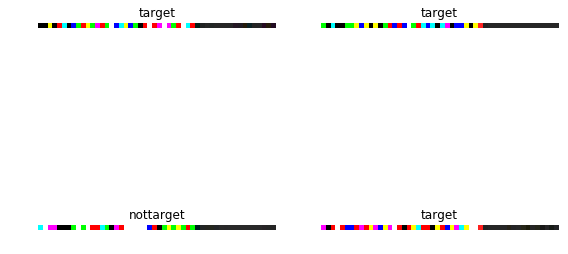

In [325]:
data.show_batch(rows=2)

# Model setup

## Basic model for fastai training

In [311]:
# resize input sequence array from (bs, 3, 1, 50) to (bs, 3, 50) for Conv1d layer
def ResizeInput(): return Lambda(lambda x: x.permute(0,2,1,3).view((-1,)+x.permute(0,2,1,3).size()[-2:]))

In [312]:
drop_p = 0.2

In [313]:
net_basic_fastai = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=3, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #Debugger()
                   )

In [314]:
net_basic_fastai

Sequential(
  (0): Lambda()
  (1): Conv1d(3, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Dropout(p=0.2)
  (5): Linear(in_features=288, out_features=16, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.2)
  (8): Linear(in_features=16, out_features=2, bias=True)
)

In [244]:
# initialize weights with kaiming normal initialization
#apply_init(net_basic_fastai, nn.init.kaiming_normal_)

# Model training

## Train basic model with fastai

In [315]:
learn = Learner(data, net_basic_fastai, loss_func=F.binary_cross_entropy_with_logits, metrics=accuracy_thresh)

In [316]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Lambda               [64, 3, 50]          0          False     
______________________________________________________________________
Conv1d               [64, 32, 39]         1184       True      
______________________________________________________________________
MaxPool1d            [64, 32, 9]          0          False     
______________________________________________________________________
Lambda               [64, 288]            0          False     
______________________________________________________________________
Dropout              [64, 288]            0          False     
______________________________________________________________________
Linear               [64, 16]             4624       True      
______________________________________________________________________
ReLU                 [64, 16]             0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


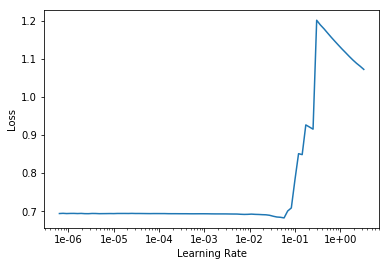

In [317]:
learn.lr_find()
learn.recorder.plot()

In [318]:
learn.fit_one_cycle(10, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.571930,0.521825,0.764000
2,0.522738,0.527210,0.759600
3,0.504971,0.574019,0.715300
4,0.500220,0.502050,0.774200
5,0.477877,0.475824,0.788400
6,0.438131,0.456172,0.803000
7,0.435762,0.448004,0.798400
8,0.391101,0.413436,0.816400
9,0.374293,0.393267,0.826000
10,0.360177,0.389903,0.827400


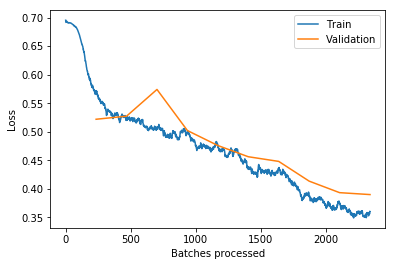

In [319]:
learn.recorder.plot_losses()

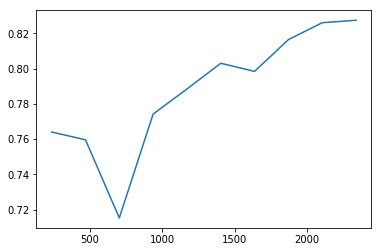

In [320]:
learn.recorder.plot_metrics()

In [321]:
learn.fit_one_cycle(20, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.365177,0.379553,0.830800
2,0.354358,0.384583,0.829800
3,0.345974,0.354708,0.834800
4,0.362023,0.346883,0.842400
5,0.363330,0.336041,0.849400
6,0.355574,0.322405,0.847400
7,0.363510,0.348670,0.853600
8,0.364006,0.314748,0.856600
9,0.332879,0.274864,0.879200
10,0.302273,0.258379,0.888200


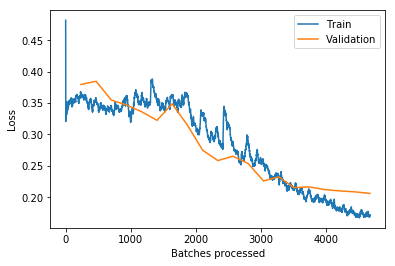

In [322]:
learn.recorder.plot_losses()

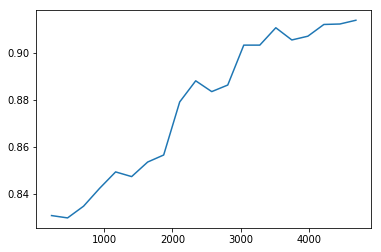

In [324]:
learn.recorder.plot_metrics()

In [265]:
learn.fit(10, lr=1e-2)

epoch,train_loss,valid_loss,accuracy_thresh
1,0.674056,0.631824,0.627000
2,0.625776,0.536364,0.776000
3,0.574057,0.466983,0.798000
4,0.522799,0.444743,0.816000
5,0.474495,0.401542,0.837000
6,0.434180,0.439541,0.805000
7,0.402628,0.399104,0.842000
8,0.384192,0.402352,0.842000
9,0.353875,0.411291,0.816000
10,0.324533,0.417372,0.822000


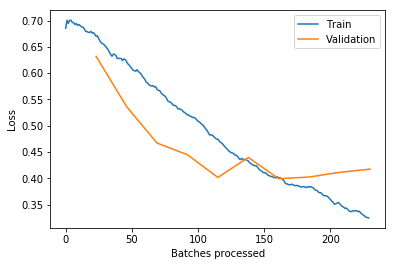

In [266]:
learn.recorder.plot_losses()

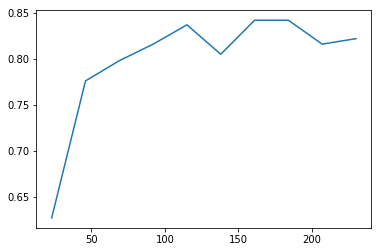

In [267]:
learn.recorder.plot_metrics()

# Interpretation

In [268]:
interpret = learn.interpret()

In [270]:
#interpret.confusion_matrix() # does not work yet!

In [1]:
#debug_memory()